[Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification/overview)

[Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2/)

# Going faster

In [1]:
from fastai.vision.all import *
from fastkaggle import *

set_seed(42)

path = Path("./input")
path, path.ls()

(Path('input'),
 (#4) [Path('input/sample_submission.csv'),Path('input/test_images'),Path('input/train.csv'),Path('input/train_images')])

In [3]:
trn_path = path / "sml"
trn_path

Path('input/sml')

fastai의 `resize_images` 함수를 사용해 이미지를 처리하려고 합니다. max_size를 256으로 설정해 이미지의 가로, 세로 중 더 긴 쪽이 256픽셀이 되도록 리사이징합니다.

In [5]:
resize_images(path / "train_images", dest=trn_path, max_size=256, recurse=True)

This will give us 192x256px images. Let's take a look:

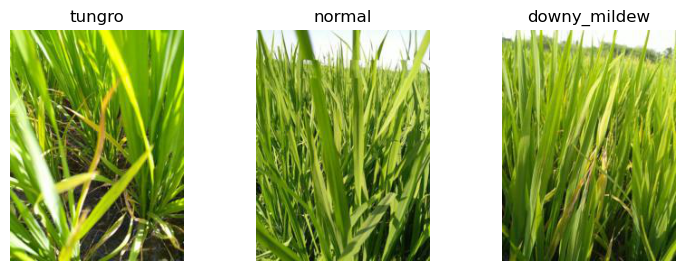

In [6]:
dls = ImageDataLoaders.from_folder(
    trn_path, valid_pct=0.2, seed=42, item_tfms=Resize((256, 192))
)

dls.show_batch(max_n=3)

In this notebook, we'll be experimenting with a few different architectures and image processing approaches(item and batch transforms). In order to make this easier, we'll put our modeling steps together into a little function which we can pass the architecture, item transforms, and batch transforms to:

In [7]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(
        trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch
    )
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

Our `item_tfms` already resize our images to small sizes, so this shouldn't impact the accuracy of our models much, if at all. Let's re-run our resnet26d to test.

In [8]:
learn = train(
    "resnet26d", item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75)
)

C:\Users\jiweo\anaconda3\envs\kaggle-torch\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
C:\Users\jiweo\anaconda3\envs\kaggle-torch\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.962944,1.357006,0.438731,01:56


epoch,train_loss,valid_loss,error_rate,time
0,1.266892,0.981407,0.327727,00:34
1,1.017243,0.736736,0.238347,00:33
2,0.714853,0.501092,0.165786,00:34
3,0.531189,0.439583,0.142720,00:33
4,0.449253,0.404504,0.127823,00:34


That's a big improvement in speed, and the accuracy looks fine.

# A ConvNeXt model

I noticed that the GPU usage bar in Kaggle was still nearly empty, so we're still CPU bound. That means we should be able to use a more capable model with little if any speed impact. Let's look agina at the options in [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning) `convnext_small` tops the performance/accuracy tradeoff score there, so let's give it a go!

In [12]:
arch = "convnext_small.fb_in22k"

In [13]:
learn = train(
    arch,
    item=Resize(192, method="squish"),
    batch=aug_transforms(size=128, min_scale=0.75),
)

epoch,train_loss,valid_loss,error_rate,time
0,1.288069,0.798918,0.246036,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.640999,0.447463,0.144642,00:48
1,0.487304,0.356211,0.111485,00:48
2,0.322406,0.244802,0.079289,00:48
3,0.186130,0.172900,0.053820,00:48
4,0.124910,0.160344,0.049495,00:48


Wow our error rate has halved! That's a great result. And, as expected, the speed hasn't gone up much at all. This seems like a greate model for iterating on.

# Preprocessing experiments

So, what shall we try first? One thing which can make a difference is wheter we "squish" a rectangular image into a square shape by changing it's aspect ratio, or randomly crop out a square from it, or whether we add black padding to the edges to make it square. In the previous version we "squished". Let's try "crop" instead, which is fastai's default.

In [14]:
learn = train(arch, item=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.364566,0.868600,0.281115,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.673811,0.538639,0.166266,00:45
1,0.533625,0.363380,0.111965,00:46
2,0.358883,0.252676,0.077367,00:45
3,0.238182,0.179493,0.054781,00:46
4,0.177129,0.158359,0.051418,00:47


That doesn't seem to have made much difference...

We can also try padding, which keeps all the original image without transforming it -- here's what that looks like:

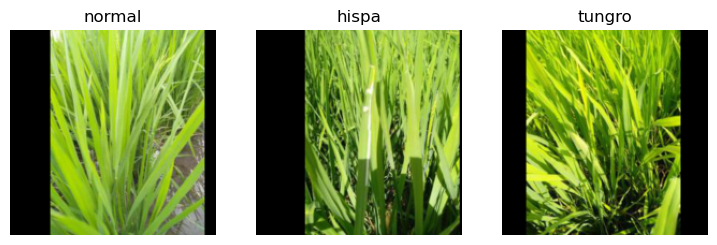

In [15]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
)
dls.show_batch(max_n=3)

In [19]:
learn = train(
    arch,
    item=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(171, 128), min_scale=0.75),
)

C:\Users\jiweo\anaconda3\envs\kaggle-torch\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
C:\Users\jiweo\anaconda3\envs\kaggle-torch\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.296825,0.890974,0.267179,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.671673,0.441543,0.141759,00:48
1,0.518778,0.344614,0.115810,00:49
2,0.335745,0.207837,0.062470,00:48
3,0.209317,0.153170,0.049976,00:48
4,0.135191,0.134801,0.038443,00:48


That's looking like pretty good improvement.

# Test time augmentation

## 개요
Test Time Augmentation (TTA)는 **추론 및 테스트 과정**에서 성능을 향상시키기 위해 사용하는 기법입니다. TTA는 훈련된 모델에 대해 **다양한 데이터 증강을 적용한 이미지**들을 생성한 후, 각각의 이미지에서 얻은 예측값을 **평균**하거나 **최대값**으로 결합하여 최종 예측을 도출합니다. 이를 통해 **추론 시 모델의 성능**을 향상시킬 수 있습니다.

## 주요 특징
- **추론 시 사용**: 훈련이 완료된 모델에서 성능을 평가하거나 추론할 때 적용됩니다.
- **여러 증강 이미지 사용**: 단일 이미지가 아닌, 여러 변형된 이미지를 모델에 입력하여 각각의 예측을 얻습니다.
- **결합 방식**: 각 예측값들을 **평균**하거나 **최대값**으로 결합하여 최종 예측값을 만듭니다.
- **훈련 과정에는 영향 없음**: TTA는 추가적인 훈련 없이 성능을 향상시키며, 훈련 시간에는 영향을 주지 않습니다.

## 장점
- **노이즈 감소**: 단일 이미지에서 발생할 수 있는 노이즈를 여러 증강 이미지의 평균을 통해 상쇄합니다.
- **일반화 성능 향상**: 다양한 증강 이미지에 노출되면서 모델의 일반화 성능이 높아집니다.
- **작은 객체 보호**: 중요한 세부 정보가 이미지의 외곽에 있을 때, 중앙 크롭이 아닌 다양한 위치의 크롭을 통해 중요한 정보를 보존할 수 있습니다.

## 단점
- **추론 시간 증가**: TTA를 사용할 경우, 사용하는 증강 이미지의 수에 따라 추론 시간이 증가합니다. 예를 들어, 5개의 증강 이미지를 사용할 경우 추론 시간이 5배 느려집니다.

## 사용 예시 (Fastai)
```python
# 기본 TTA 적용
preds, targs = learn.tta()

# n_augments로 증강 이미지 수 지정
preds, targs = learn.tta(n_augments=8)

# 예측값을 결합할 때 'max'로 변경
preds, targs = learn.tta(merge='max')


To make the predictions even better, we can try [test time augmentation](https://nbviewer.org/github/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb#Test-Time-Augmentation)(TTA).

Before trying that out, we'll first see how to check the predictions and error rate of our model without TTA:

In [23]:
valid = learn.dls.valid  # 검증 데이터셋
preds, targs = learn.get_preds(
    dl=valid
)  # 데이터 로더에서 모델의 예측값과 실제 정답을 가져옴

In [24]:
error_rate(preds, targs)

TensorBase(0.0384)

That's the same error rate we saw at the end of training, above, so we know that we're doing that correctly.

Here's what our data augmentation is doing -- if you look carefully, you can see that each image is a bit lighter or darker, sometimes flipped, zoomed, rotated, warped, and/or zoomed:

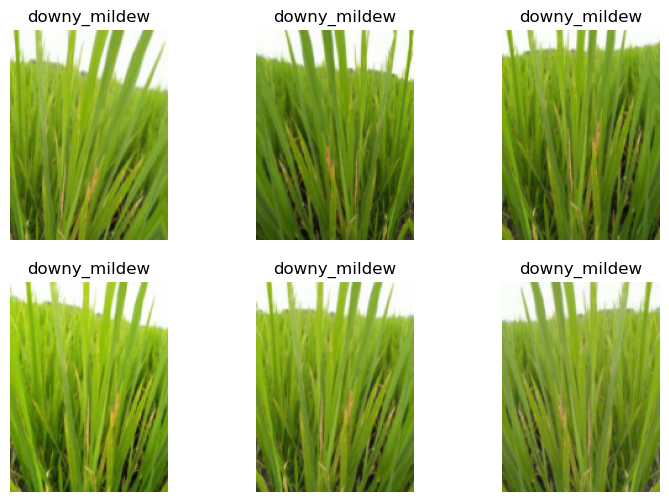

In [25]:
learn.dls.train.show_batch(max_n=6, unique=True)

If we call `tta()` then we'll get the average of predictions made for multiple different augmented versions of each image, along with the unaugmented original:

In [26]:
tta_preds, _ = learn.tta(dl=valid)

In [27]:
error_rate(tta_preds, targs)

TensorBase(0.0351)

That's a huge improvement! We'll definitely want to use this for any submission we make!

# Scaling up

Now that we've got a pretty good model and preprocessing approach, let's scale it up to larger images and more epochs. We'll switch back our path to the original un-resized images, and use 12 epochs using our best settings so far, with larger final augmented images:

In [28]:
trn_path = path / "train_images"

In [29]:
learn = train(
    arch,
    epochs=12,
    item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(256, 192), min_scale=0.75),
)

epoch,train_loss,valid_loss,error_rate,time
0,1.095742,0.700798,0.209034,02:13


epoch,train_loss,valid_loss,error_rate,time
0,0.519675,0.309485,0.099471,02:16
1,0.403538,0.275136,0.084094,02:17
2,0.342973,0.248388,0.072561,02:16
3,0.306752,0.175258,0.051418,02:18
4,0.219665,0.213395,0.066314,02:17
5,0.182284,0.210511,0.058145,02:17
6,0.134710,0.151188,0.037963,02:17
7,0.093379,0.117854,0.029313,02:17
8,0.077003,0.107599,0.026910,02:17
9,0.053011,0.095147,0.026430,02:16


This is around twice as accurate as our previous best model - let's see how it performs with TTA too:

In [30]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0226)

Once again, we get a big boost from TTA. That is one of the most under-appreciated deep learning tricks, in my opinion!(I'm not sure there's any other frameworks that make it quite so easy, so perhaps that's part of the reason why...)

# Submission

We're no ready to get our Kaggle submissions sorted. First, we'll grab the test set like we did in the last notebook:

In [31]:
tst_files = get_image_files(path / "test_images").sorted()
tst_dl = learn.dls.test_dl(tst_files)

Next, do TTA on that test set:

In [32]:
preds, _ = learn.tta(dl=tst_dl)

We need to indices of the largest probability prediction in each row, since that's the index of the predicted disease. `argmax` in pytorch gives us exactly that:

In [33]:
idxs = preds.argmax(dim=1)

Now we need to look up those indices in the `vocab`. Last time we did that using pandas, although since then I realised there's an even easier way!

In [34]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [35]:
ss = pd.read_csv(path / "sample_submission.csv")
ss["label"] = results
ss.to_csv("subm2.csv", index=False)
!head subm2.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


This gets a score of 0.9827, which is well within the top 25% of the competition -- that's a big improvement, and we're still using a single small model!

# Conclusion

We've made a big step today. Next time, we'll try scaling up to some bigger models and doing some ensembling.

[Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3)